# Extracting data

In [1]:
import spatial_data
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
xr.set_options(display_style='text')

In [2]:
ds = xr.load_dataset('/g/huber/projects/CITEseq/CODEX/BNHL_TMA/bhnl_labeled_zarr/166_4_I2_LK_labeled.zarr')

/home/voehring/voehring/conda/pymc_env/lib/python3.11/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/voehring/voehring/conda/pymc_env/lib/python3.11/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


## Extracting information

Once the image and segmentation masks are loaded in the `xarray` object we can leverage the `pp.add_quantification()` accessor to capture the expression of each cell across the image channels (see also the Importing and saving data tutorial).

The `pp.add_quantification()` accessor returns an `xarray` with the coordinates `cells` and `channels`. By default it will sum the intensity over the region of each cell. The `key_added` argument allows us to specify the name of the added `xararray.DataArray`.

In [28]:
ds = ds.pp.add_quantification(key_added='_sum_intensity')

It is easy to write custom functions for `pp.add_quantification`. These must accept two arguments `regionmask` and `intensity_image` and return the value of interest. The following function calculates the log expression over the segemented cell(s).

In [30]:
def log_intensity(regionmask, intensity_image):
    return np.log(np.sum(intensity_image[regionmask])+1)

In [32]:
ds.pp.add_quantification(func=log_intensity, key_added='_log_intensity')

<xarray.Dataset>
Dimensions:         (cells: 12560, channels: 56, y: 3000, x: 3000, labels: 8,
                     props: 2, features: 4)
Coordinates:
  * cells           (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * channels        (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * features        (features) <U10 'centroid-0' 'centroid-1' ... '_original_'
  * labels          (labels) int64 1 2 3 4 5 6 7 8
  * props           (props) <U6 '_color' '_name'
  * x               (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y               (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
Data variables:
    _arcsinh_mean   (cells, channels) float64 3.111 0.0 1.391 ... 1.324 0.4174
    _arcsinh_sum    (cells, channels) float64 8.346 0.0 6.564 ... 6.625 5.224
    _image          (channels, y, x) uint8 4 4 4 4 5 4 4 3 4 ... 2 2 2 2 2 2 2 2
    _labels         (labels, props) object 'C3' ... 'B (PAX5)'
    _obs            (cells, features) float64 613.3 768.4 4.0 ... 8.0 7.0
    _raw_mean       (cells, channels) float64 56.02 0.0 9.426 ... 8.727 2.148
    _raw_sum        (cells, channels) float64 1.053e+04 0.0 ... 1.885e+03 464.0
    _segmentation   (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _sum_intensity  (cells, channels) float64 1.053e+04 0.0 ... 1.885e+03 464.0
    _log_intensity  (cells, channels) float64 9.262 0.0 7.48 ... 7.542 6.142

## Inspecting the expression of specific cells

In the following section we illustrate how to pull out the expression spectra of specific cells. We start by inspecting the region of interest by slicing the respective region and cell types using the preprocesing `.pp[]` and label `.la[]` accessor.

Dropped 11931 cells.


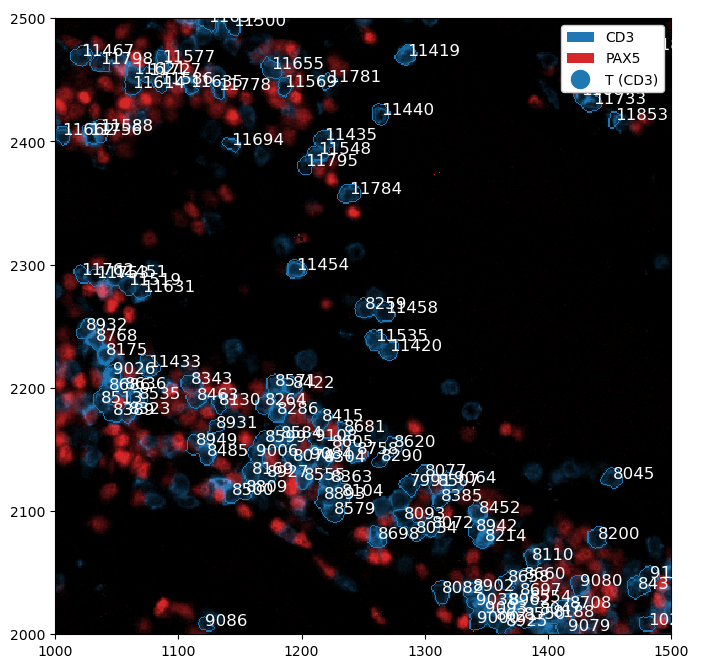

In [37]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

_ = (ds
     .pp[['CD3', 'PAX5'], 1000:1500, 2000:2500] # select CD3 and PAX5
     .pp.colorize(colors=['C0', 'C3']) # assign colors to the channels CD3 and PAX5
     .la['T (CD3)'] # subset T cells (CD3+)
     .la.render_label() # render labels
     .pl.imshow(legend_label=True, legend_background=True, ax=ax) 
     .pl.annotate()
    )

To extract the expression spectra of the T cells we simply subset the region and cells followed by `pp.add_quantification()`.

In [45]:
da = ds.pp[1000:1500, 2000:2500].la['T (CD3)'].pp.add_quantification()

Dropped 11931 cells.


We obtain a `xarray` data array that contains the expression of our cell selection.

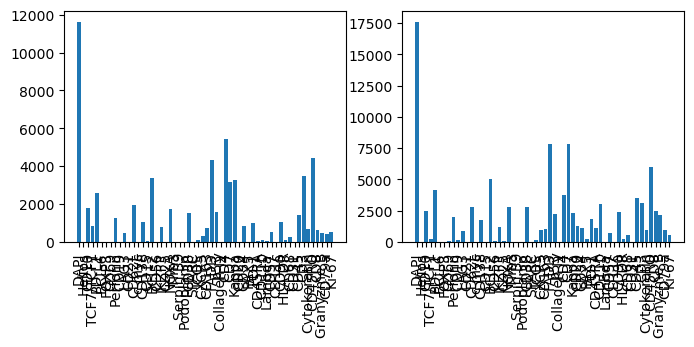

In [48]:
_ = da.pl.spectra(cells=[8045, 8200], layers_key='_sum_intensity')